# Autodiff

We saw how the backpropagation algorithm can be used to find gradients for any neural network, as long as each step in its computational graph is differentiable. Working from the end of the computational graph (output) toward the beginning (input), we can use the chain rule to get the derivate of the output with respect to each weight.

However, outside of [toy examples](https://colab.research.google.com/github/ffund/ml-notebooks/blob/master/notebooks/8-demo-backprop.ipynb), we don't train modern neural networks by working out these derivatives and then implementing them in code. Modern neural networks are enabled by frameworks for automatic differentiation (like Tensorflow and Pytorch), which build the computational graph and apply the backpropagation algorithm to it without us having to compute derivatives by hand.

In this exercise, we will build our own very basic framework for **automatic differentiation**, to better understand how it works.

|Name|	Type|	Description|
| --- | --- | --- |
|`sub`	|function	|Function to subtract two Variables|
|`square`	|function	|Function to compute the square of a Variable|
|`sigmoid`	|function	|Function to compute the sigmoid function of a Variable|
|`wh`	|instance of a Variable	|Weight at hidden layer, with value and accumulated gradient|
|`wo`	|instance of a Variable	|Weight at output layer, with value and accumulated gradient|
|`L`	|instance of a Variable	|Loss, with value and accumulated gradient|

In [1]:
import numpy as np
from IPython.display import Image, display, SVG
# utility functions I wrote for visualization
from vis import vis_forward_pass, vis_backward_pass 

We saw how the backpropagation algorithm can be used to find gradients for any neural network, as long as each step in its computational graph is differentiable. Working from the end of the computational graph (output) toward the beginning (input), we can use the chain rule to get the derivate of the output with respect to each weight.

However, outside of [toy examples](https://colab.research.google.com/github/ffund/ml-notebooks/blob/master/notebooks/8-demo-backprop.ipynb), we don't train modern neural networks by working out these derivatives and then implementing them in code.  Modern neural networks are enabled by frameworks for **automatic differentiation** (like Tensorflow and Pytorch), which build the computational graph and apply the backpropagation algorithm to it without us having to compute derivatives by hand.

In this exercise, we will build our own very basic framework for automatic differentiation, to better understand how it works.


### Build a Variable class and some operations

In our framework, a `Variable` will represent a node in the computational graph and holds these essential pieces of information:

* `value` - the value of the variable.
* `local_gradients` - the local derivative, i.e. the derivative of the operation that this node performs with respect to its arguments.
* `accumulated_gradient` - the accumulated gradient we will compute in the backwards pass along the computational graph.

 (We'll also add a `name` attribute so that we can visualize our computational graph.)

Here is our `Variable` class:

In [2]:
class Variable:
    def __init__(self, value, local_gradients=(), name=None):
        self.value = value
        self.local_gradients = local_gradients
        self.accumulated_gradient = 0
        self.name = name or f"Var_{id(self)}"


Of course, we want to support some operations on our variables. Let's implement addition (`add`) and multiplication (`mul`).

For each operation, we should return a new instance of a `Variable` with:

* the `value` that is the output of this operation for the forward pass on the computational graph,
* and the `local_gradients` of this operation, that we can use for the backward pass on the computational graph.

In [3]:
def add(a, b):
    "Create the variable that results from adding two variables."
    value = a.value + b.value
    local_gradients = (
        (a, 1),  # the local derivative with respect to a is 1
        (b, 1)   # the local derivative with respect to b is 1
    )
    return Variable(value, local_gradients, name=f"({a.name}+{b.name})")

def mul(a, b):
    "Create the variable that results from multiplying two variables."
    value = a.value * b.value
    local_gradients = (
        (a, b.value), # the local derivative with respect to a is b.value
        (b, a.value)  # the local derivative with respect to b is a.value
    )
    return Variable(value, local_gradients, name=f"({a.name}*{b.name})")


Now, we can use this basic framework to do a forward pass on a graph. We'll define two variables, `a` and `b`, and give them values:

In [4]:
a = Variable(4, name='a')
b = Variable(3, name='b')

Note that both of these have "empty" `local_gradients` and zero `accumulated_gradient`, to start:

In [5]:
a.local_gradients, b.local_gradients

((), ())

In [6]:
a.accumulated_gradient, b.accumulated_gradient

(0, 0)

If we `add` the variables:

In [7]:
c = add(a, b)

we get a new `Variable` whose `value` is the output of the "forward pass":


In [8]:
c.value

7

and also has `local_gradients` with respect to the variables `a` and `b`:

In [9]:
for grad in c.local_gradients:
    print('Gradient with respect to', grad[0].name, ':', grad[1])

Gradient with respect to a : 1
Gradient with respect to b : 1


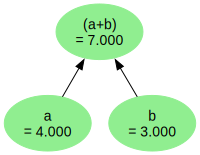

In [10]:
vis_forward_pass(c)

Note: each node in this graph is its own `Variable`.

### Build the backward pass


We will need a `get_gradients` function. It will operate as follows, using recursion:

* First, it will start at the final output node of the computational graph. We will call `compute_gradients` on that output `Variable`. We will pass a `path_value` of 1 to `compute_gradients` - this is the gradient of that output `Variable` with respect to itself. As we traverse the graph, we will be accumulating the gradient *of this output variable* with respect to each node in the graph.
* Inside the `compute_gradients` function, we get the `local_gradients` of the node and iterate over them - these are the child nodes of this node when traversing the graph for the backward pass. For each child node and the gradient with respect to that child node:
  * we multiply the values along the edges: the `path_value` up until this node, times the `local_gradient` of this node with respect to this child.
  * and then we add this to the `accumulated_gradient` of the child node - i.e. we will sum the path values for all paths to this child.
  * finally, we call `compute_gradients` again on this *child* node, passing the `path_value` we have computed, to continue recursing on the graph.
* When we reach the input nodes, they do not have any `local_gradients` so the recursion will end.

In [11]:
def get_gradients(output_variable):
    """ Compute the first derivatives of `variable`
    with respect to child variables.
    """

    def compute_gradients(variable, path_value):
        for child_variable, local_gradient in variable.local_gradients:
            # "Multiply the edges of a path":
            value_of_path_to_child = path_value * local_gradient
            # "Add together the different paths":
            child_variable.accumulated_gradient += value_of_path_to_child
            # recurse through graph:
            compute_gradients(child_variable, value_of_path_to_child)

    # start here
    compute_gradients(output_variable, path_value=1)
    # (path_value=1 is from `variable` differentiated w.r.t. itself)
    output_variable.accumulated_gradient = 1

Let's try it now. We will use the example from Figure 20 in the lecture handout.

In [12]:
a = Variable(2, name='a')
b = Variable(1, name='b')
c = add(a, b)
d = add(b, Variable(1, name='1'))
e = mul(c, d)

In [13]:
e.value

6

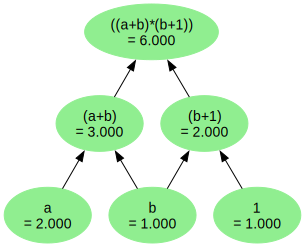

In [14]:
vis_forward_pass(e)

In [15]:
get_gradients(e)

In [16]:
(a.accumulated_gradient, b.accumulated_gradient)

(2, 5)

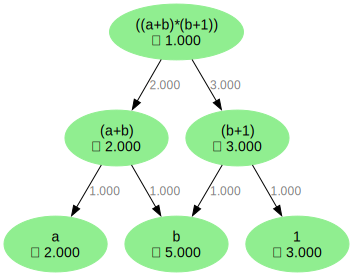

In [17]:
vis_backward_pass(e)

(you can confirm that this matches Figure 22 in the lecture handout.)

We have correctly computed the value in the forward pass and the backward pass. 

### Extend the framework

Using the framework we have developed so far, implement these additional operations, similar to the way `add` and `mul` are implemented above:

* `sub` (subtract)
* `square` (square)
* `sigmoid`

Each function should return a new `Variable` with a correct `value` and tuple of `local gradients`, as well as a `name`.

In [18]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
def sub(a, b):
    "Create the variable that results from subtracting a-b."
    value = a.value - b.value
    local_gradients = (
        (a, 1),  # the local derivative with respect to a is 1
        (b, -1)  # the local derivative with respect to b is -1
    )
    return Variable(value, local_gradients, name=f"({a.name}-{b.name})")

Note: for a function that takes a single input, `local_gradients` will have one element but should still be defined as a tuple. When you define `local_gradients`, you will use e.g. 

```
local_gradients = (
    (?, ?),
)
```

with the comma being strictly required in order for it to be a tuple and not just a value.

In [19]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
def square(a):
    "Create the variable that results from squaring the variable a, i.e. a^2."
    value = a.value ** 2
    local_gradients = (
        (a, 2 * a.value),  # the local derivative with respect to a is 2*a
    )
    return Variable(value, local_gradients, name=f"({a.name}^2)")

In [20]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
def sigmoid(a):
    "Create the variable that results from applying a sigmoid function to a."
    value = 1 / (1 + np.exp(-a.value))
    local_gradients = (
        (a, value * (1 - value)),  # the local derivative of sigmoid
    )
    return Variable(value, local_gradients, name=f"sigmoid({a.name})")

### Build a neural network

With these new operations, we can construct the computational graph shown in Figure 15 in the lecture handout, where:

data sample - 

* let the value of `x` be 4
* let the value of `y` be 1

initial weights - 

* let the value of `wh` be -2
* let the value of `wo` be 3

activation and loss functions - 

* let the activation function at the hidden unit be sigmoid
* let the activation function at the output unit be linear
* use the mean squared error loss function: $(y-\hat{y})^2$


In [21]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# Input Variables
x = Variable(4, name='x')
y = Variable(1, name='y')
wh = Variable(-2, name='wh')
wo = Variable(3, name='wo')

# Variables created by operations on those input Variables
zh = mul(x, wh)
uh = sigmoid(zh)
zo = mul(uh, wo)
uo = zo
L = square(sub(uo, y))

Visualize the forward pass:

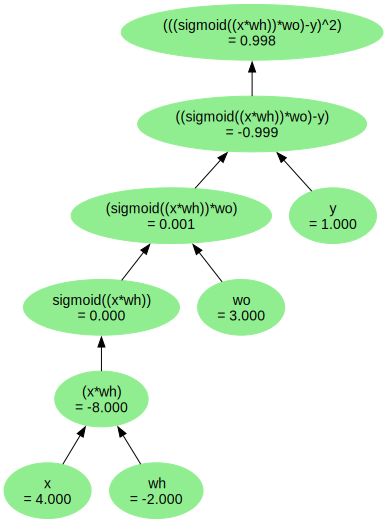

In [22]:
vis_forward_pass(L)

Then, do a backward pass to get the gradient of the loss function with respect to each of the weights.

In [23]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
get_gradients(L)

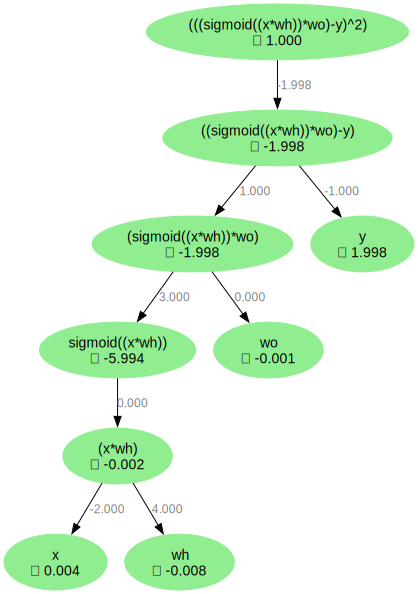

In [24]:
vis_backward_pass(L)